## 1. 介绍

---

将Transformer用在视觉领域，效果要比CNN好。

[ViT论文](https://arxiv.org/abs/2010.11929)

Transformer的输入是 batch_size, seq_len  
而图片的输入是 batch_size, channels, width, heights  
ViT为了实现序列化的效果，对图片进行了等大小的裁切，比如图片大小3×96×96，裁切成3×16×16的大小，则seq_len = (96/16)^2 = 36  
这样图片输入的序列化就搞定了

词嵌入，就是将余下的维度拉直，再进行线性映射。

输出再接一个MLP

## 2. 简单实现

在CIFAR10上进行实现

In [53]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
from IPython.display import display, clear_output
from torch.amp import autocast, GradScaler
import matplotlib.pyplot as plt

In [38]:
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [42]:
class ViT(nn.Module):
    def __init__(self, image_size=96, patch_size=16, num_classes=10, dim=256, depth=4, heads=8, mlp_dim=512):
        super().__init__()
        assert image_size % patch_size == 0, "Image dimensions must be divisible by the patch size."
        num_patches = (image_size // patch_size) ** 2
        patch_dim = 3 * patch_size * patch_size

        self.patch_size = patch_size
        self.linear_patch = nn.Linear(patch_dim, dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, dropout=0.1, batch_first=True),
            num_layers=depth
        )
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        B, C, H, W = x.shape
        p = self.patch_size
        x = x.unfold(2, p, p).unfold(3, p, p)  # [B, C, n_patches_h, n_patches_w, p, p]
        x = x.contiguous().view(B, C, -1, p, p).permute(0, 2, 1, 3, 4)  # [B, N, C, p, p]
        x = x.flatten(2)  # [B, N, patch_dim]
        x = self.linear_patch(x)  # [B, N, dim]

        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, dim]
        x = torch.cat((cls_tokens, x), dim=1)  # [B, N+1, dim]
        x = x + self.pos_embedding[:, :x.size(1)]
        x = self.transformer(x)
        return self.mlp_head(x[:, 0])  # 用cls token表示图像

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
scaler = GradScaler()

In [44]:
summary(model, input_size=(64, 3, 96, 96))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [64, 10]                  9,728
├─Linear: 1-1                                 [64, 36, 256]             196,864
├─TransformerEncoder: 1-2                     [64, 37, 256]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [64, 37, 256]             527,104
│    │    └─TransformerEncoderLayer: 3-2      [64, 37, 256]             527,104
│    │    └─TransformerEncoderLayer: 3-3      [64, 37, 256]             527,104
│    │    └─TransformerEncoderLayer: 3-4      [64, 37, 256]             527,104
├─Sequential: 1-3                             [64, 10]                  --
│    └─LayerNorm: 2-2                         [64, 256]                 512
│    └─Linear: 2-3                            [64, 10]                  2,570
Total params: 2,318,090
Trainable params: 2,318,090
Non-trainab

In [60]:
# 定义训练函数
def train(epoch):
    model.train()
    train_loss = 0
    correct_num = 0
    total_num = 0
    
    # 遍历训练数据
    for data, label in train_loader:
        # 将数据和标签挪到GPU  
        data, label = data.to(device), label.to(device)
        
        optimizer.zero_grad() # 梯度清理
        with autocast(device_type='cuda'):
            output = model(data)
            loss = criterion(output, label)
        # 使用 GradScaler 进行 loss 反向传播
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()  #计算总损失
        preds = torch.argmax(output, dim=1)
        correct_num += torch.eq(preds, label).sum().item() # 预测正确数量
        total_num += label.size(0) # 总预测数量

        #手动释放显存
        del data, label, output, loss
        torch.cuda.empty_cache()

    train_loss = train_loss/len(train_loader) # 计算平均训练损失
    accuracy = correct_num/total_num # 计算准确率
    train_losses.append(train_loss)
    train_accuracies.append(accuracy)
    print(f'Epoch:{epoch}\tTraining Loss:{train_loss:.6f}, Accuracy:{accuracy:.6f}') # 输出信息

In [61]:
# 定义验证函数并初始化
def evaluate(epoch): 
    model.eval() # 验证模式
    evaluate_loss = 0 #累积验证损失
    correct_num = 0 
    total_num = 0 
    
    # 禁用梯度
    with torch.no_grad():
        # 遍历测试数据
        for data, label in test_loader: 
            # 将数据和标签挪到GPU  
            data, label = data.to(device), label.to(device)
            with torch.amp.autocast(device_type='cuda'):  # 同样使用半精度
                output = model(data)
                loss = criterion(output, label)

            evaluate_loss += loss.item() # 累积总损失
            preds = torch.argmax(output, dim=1)
            correct_num += torch.eq(preds, label).sum().item() # 预测正确数量
            total_num += label.size(0) # 总预测数量
    accuracy = correct_num/total_num # 计算准确率
    evaluate_loss = evaluate_loss/len(test_loader) # 计算平均验证损失
    test_accuracies.append(accuracy)
    print(f'Epoch:{epoch}\tValidation Loss:{evaluate_loss:.6f}, Accuracy:{accuracy:.6f}') #打印输出信息

In [62]:
best_accuracy = 0.0
def save_model_if_best(epoch, accuracy):
    global best_accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), f"best_vit_epoch{epoch}_acc{accuracy:.4f}.pth")
        print(f"Saved Best Model at Epoch {epoch} with Accuracy: {accuracy:.4f}")

In [63]:
# 初始化数据
train_losses = []
train_accuracies = []
test_accuracies = []

# 设置 x 轴范围
initial_x_range = 10
x_range = initial_x_range  # 初始的 x 轴范围

# 画图函数
def plot_graph(epoch):
    global x_range

    # 如果 epoch 数量大于 x 轴范围的上限，就扩展 x 轴范围
    if epoch > x_range:
        x_range += 10
    
    clear_output(wait=True)  # 清除上一次的图表
    
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 绘制训练损失（左 y 轴）
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Train Loss', color='tab:red')
    ax1.plot(range(1, len(train_losses) + 1), train_losses, color='tab:red', 
             label='Train Loss', linewidth=0.8, marker='o', markersize=4, markeredgecolor='black')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.set_xlim(0, x_range)

    # 创建右侧 y 轴（准确率）
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, color='tab:blue', 
             label='Train Accuracy', linewidth=0.8, marker='s', markersize=4, markeredgecolor='black')
    ax2.plot(range(1, len(test_accuracies) + 1), test_accuracies, color='tab:green', 
             label='Test Accuracy', linewidth=0.8, marker='^', markersize=4, markeredgecolor='black')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # 获取 ax1 和 ax2 的图例并合并
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2

    # 添加合并后的图例
    legend = ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.65, 0.5), fontsize=8, markerscale=1.2, frameon=False)

    # 调整图例位置，避免遮挡折线
    ax1.add_artist(legend)

    plt.title('Training Loss and Accuracy')
    plt.show()

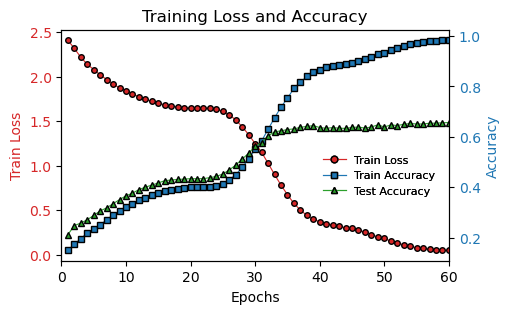

In [64]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
epochs = 60
# 训练和评估循环
for epoch in range(1, epochs + 1):
    train(epoch)
    scheduler.step()
    evaluate(epoch)
    plot_graph(epoch)  # 更新图表